# MAC0460 / MAC5832 (2025)
<hr>

# EP3: Logistic regression (binary classification)

### Objectives:

- to implement and test the logistic regression algorithm (binary classification with labels 0 and 1)

### What to do:
Some cells of this notebook must be filled. Cells to be filled are <mark>highlighted</mark> and places to be filled are indicated as:
<code>
    # YOUR CODE HERE:
</code>
<hr>

## INSTRUCTIONS

1. Fill in your identificatin information in the cell below, before submitting this notebook.
2. Submit only this **notebook with all required cells filled and with the results of the execution** of all code cells
3. Do not change function names and parameters
4. Questions should be posted in the e-disciplinas discussion forum or sent to  mlimemonitoria@gmail.com
5. By submitting this EP, you declare that the content being submitted is the result of your own work, and you did not resort to unethical means to do the EP.

### IDENTIFICATION

* Your name ==> _<mark>Laufernando Souza Dias</mark>_
* Pós, graduação, especial, ouvinte? ==> _<mark>Graduação</mark>_
* If you used some specific external source material or AI-based tools like ChatGPT or similar ones to do the EP, describe the sources you used and how they were used.<br>
==> _<mark>Documentação do Numpy + Comentários do Código em Inglês</mark>_

### For this EP we will use automatic testing

After every task, you will see a test cell to check your solution. We encourage you to experiment with these values to ensure your code is correct

In [1]:
# All imports

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import pandas as pd

from sklearn.datasets import make_blobs

%matplotlib inline

# <font style="background-color:#abebc6">1. Training and prediction algorithms</font>

We will use the formulation discussed in class: we use 1 for the positive class label and 0 for the negative class label. See Section 3.3.1 of "Notas de aula".

In the next four code cells, write the code for the specified functions. These functions will be used afterwards for some training and prediction cases. Use vectorial computation with NumPy.

In [2]:
# this is the sigmoid function. Just use it
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

## <font style="background-color: #f7dc6f">1.1. Cross-entropy loss</font>

In [3]:
def cross_entropy_loss(w, X, y):
    """
    Computes the cross-entropy loss
    :param w: weight vector
    :type: np.ndarray(shape=(1+d,1))
    :param X: design matrix
    :type X: np.ndarray(shape=(N,1+d))
    :param y: class labels
    :type y: np.ndarray(shape=(N,1))
    :return loss: cross-entropy loss
    :rtype: float
    """
    # Compute linear combination: X * w
    z = X @ w

    # Compute sigmoid probabilities: p = 1 / (1 + exp(-z))
    # Using np.clip to avoid numerical instability + Prevent overflow
    z_clipped = np.clip(z, -500, 500)
    p = 1 / (1 + np.exp(-z_clipped))

    # Clip probabilities to avoid log(0)
    p_clipped = np.clip(p, 1e-15, 1 - 1e-15)

    # Compute cross-entropy loss
    N = X.shape[0]
    loss = -1/N * np.sum(y * np.log(p_clipped) + (1 - y) * np.log(1 - p_clipped))

    return float(loss)

In [4]:
# TEST CELL
X_test = np.array([[1., 2.], [1., 3.], [1., 4.]])
y_test = np.array([[0.], [1.], [1.]])
w_test = np.array([[0.], [1.]])
expected_cost = 0.731222
assert np.isclose(cross_entropy_loss(w_test, X_test, y_test), expected_cost, atol=1e-1), "Test for cross_entropy_loss failed"


## <font style="background-color: #f7dc6f">1.2. Gradient of the cross-entropy loss</font>

In [5]:
def cross_entropy_gradient(w, X, y):
    """
    Computes the gradient of the loss function
    :param w: weight vector
    :type: np.ndarray(shape=(1+d,1))
    :param X: design matrix
    :type X: np.ndarray(shape=(N,1+d))
    :param y: class labels
    :type y: np.ndarray(shape=(N,1))
    :return grad: gradient
    :rtype: float
    """
    # Compute linear combination: X * w
    z = X @ w

    # Compute sigmoid probabilities: p = 1 / (1 + exp(-z))
    # Using np.clip to avoid numerical instability + Prevent overflow
    z_clipped = np.clip(z, -500, 500)
    p = 1 / (1 + np.exp(-z_clipped))

    # Compute gradient: grad = 1/N * X^T * (p - y)
    N = X.shape[0]
    grad = (1/N) * X.T @ (p - y)

    return grad

In [6]:
# TEST CELL
X_test = np.array([[5., 0.], [1., 6.], [9., 2.]])
y_test = np.array([[0.], [1.], [0.]])
w_test = np.array([[0.], [7.]])
expected_grad = np.array([[3.83333084], [0.66666611]])
assert np.allclose(cross_entropy_gradient(w_test, X_test, y_test), expected_grad, 1e-1), "Test for cross_entropy_gradient failed"


## <font style="background-color: #f7dc6f">1.3 Logistic regression training</font>

The function below receives the extended data matrix <tt> X (shape = (N, d+1))</tt> and the ouput vector <tt>y (shape = (N,1))</tt>, and should return the final weight vector <tt>w (shape = (d+1,1))</tt> and a list of size <tt>num_iterations+1</tt> with the cross-entropy loss values at the beginning and after each of the iterations, when <tt>return_history</tt> is <tt>True</tt>, or a Null list otherwise.

If <tt>w0==None</tt>, then it must be initialized  with <tt>w0 = np.random.normal(loc = 0, scale = 1, size = X.shape[1])</tt>


In [7]:
def train_logistic(X, y, learning_rate = 1e-3, w0 = None,\
                        num_iterations = 300, return_history = False):
    """
    Computes the weight vector applying the gradient descent technique
    :param X: design matrix
    :type X: np.ndarray(shape=(N,d+1))
    :param y: class label
    :type y: np.ndarray(shape=(N,1))
    :return: weight vector
    :rtype: np.ndarray(shape=(1+d,1))
    :return: the history of loss values (optional)
    :rtype: list of floats
    """

    # Initialize the weight vector with random values
    # Here, drawn independently from a normal unit distribution
    if w0 is None:
        w0 = np.random.normal(loc = 0, scale = 1, size = X.shape[1]).reshape(X.shape[1],1)
    w = w0.copy()

    # To store the cross entropy value at each iteration
    history = []

    # Store initial loss if returning history
    if return_history:
        initial_loss = cross_entropy_loss(w, X, y)
        history.append(initial_loss)

    # Gradient descent loop
    for i in range(num_iterations):
        grad = cross_entropy_gradient(w, X, y)

        # Update weights: w = w - learning_rate * gradient
        w = w - learning_rate * grad

        # Store loss at current iteration if returning history
        if return_history:
            current_loss = cross_entropy_loss(w, X, y)
            history.append(current_loss)

    # Return results based on return_history flag
    if return_history:
        return w, history
    else:
        return w, []


In [8]:
# TEST CELL
X_test = np.array([[1., 2.], [1., 3.], [1., 4.]])
y_test = np.array([[0.], [1.], [1.]])
w_test = np.array([[0.], [0.]])
expected_w_final = np.array([[-3.19581162], [ 1.47454342]])
learning_rate = 0.05
num_iters = 1000
expected_loss_history_length = num_iters + 1
w_final, loss_history = train_logistic(X_test, y_test, learning_rate, w_test, num_iters, return_history=True)
assert np.allclose(w_final, expected_w_final, atol=1e-1), "Test failed for train_logistic: w_final incorrect"
assert len(loss_history) == expected_loss_history_length, "Test failed for train_logistic: loss history length incorrect"

w_final, loss_history = train_logistic(X_test, y_test, learning_rate, w_test, num_iters, return_history=True)


## <font style="background-color: #f7dc6f">1.4. Logistic regression prediction</font>

The function in the next cell will be used to do the prediction. Recall that the prediction is a score in $[0,1]$, given by the sigmoid value of the linear combination.

In [9]:
def predict_logistic(X, w):
    """
    Computes the logistic regression prediction
    :param X: design matrix
    :type X: np.ndarray(shape=(N,d+1))
    :param w: weight vector
    :rtype: np.ndarray(shape=(1+d,1))
    :return: predicted classes
    :rtype: np.ndarray(shape=(N,1))
    """

    # Compute linear combination: z = X * w
    z = X @ w

    # Apply sigmoid function to get predictions in [0,1]
    # p = 1 / (1 + exp(-z))
    # Using np.clip to avoid numerical instability + Prevent overflow
    z_clipped = np.clip(z, -500, 500)
    predictions = 1 / (1 + np.exp(-z_clipped))

    return predictions

In [10]:
# TEST CELL
X_test = np.array([[1., 2.], [1., 0.], [1., 4.]])
w_test = np.array([[0.], [1.]])
expected_predictions = np.array([[0.88079708], [0.5], [0.98201379]])
predictions = predict_logistic(X_test, w_test)
assert np.allclose(predictions, expected_predictions, atol=1e-1), "Test failed for prediction_logistic"



# <font style="background-color:#abebc6">2. Testing the training and prediction algorithms on toy datasets</font>

## 2.1. 2D data, separable case

### 2.1.1. Generate two blobs of points

---

In this code cell, change the variable `data_type` to produce different types of observations.
- "regular" corresponds to clean data with two distinct classes where a decision boundary can be drawn very easily.
- "unbalaced" is a type of dataset where one class has way more observations than the other.
- "overlapping" is a dataset where there is not a clearly distinct decision boundary to separate both classes (at least not in this dimension).

---

Play around with these dataset types and make observations.
You can also change the variable `unbalance_mod` to change the inbalance level between the classes or `overlap_std` to change how much the two classes overlap. For example, if `unbalance_mod = 10` there will be 10 times more example in class 2.

In [11]:
# Create two blobs
N = 300
# change this variable to test different types of data. Possible values: "regular", "unbalanced", "overlapping".
dataset_type = "unbalanced"
# change this variable to test different magnitudes of inbalance
unbalance_mod = 5
# change this variable to test different magnitudes of overlap between classes
overlap_std = 0.5

if dataset_type == "regular":
  X, y = make_blobs(n_samples=N, centers=2, cluster_std=0.1, center_box=(-1.0, 1.0), n_features=2, random_state=2)

elif dataset_type == "unbalanced":
  X, y = make_blobs(n_samples=N, centers=2, cluster_std=0.2, center_box=(-1.0, 1.0), n_features=2, random_state=2, shuffle=False)
  len_0 = (y==0).sum()
  slice_idx = int(len_0/unbalance_mod)
  X = X[len_0-slice_idx:]
  y = y[len_0-slice_idx:]
  p = np.random.permutation(len(X))
  X = X[p]
  y = y[p]

elif dataset_type == "overlapping":
  X, y = make_blobs(n_samples=N, centers=2, cluster_std=overlap_std, center_box=(-1.0, 1.0), n_features=2, random_state=2)

else:
  raise NotImplementedError("Please choose a valid dataset_type")

# Add a bias value 1 as the first coordinate of each example
Xtilde = np.concatenate([np.ones((len(X), 1)), X], axis = 1)

y = y.reshape(len(y),1)
print("X", X.shape)
print("Xtilde", Xtilde.shape)
print("y.shape =", y.shape)


X (180, 2)
Xtilde (180, 3)
y.shape = (180, 1)


### 2.1.2. Let's plot the blobs of points

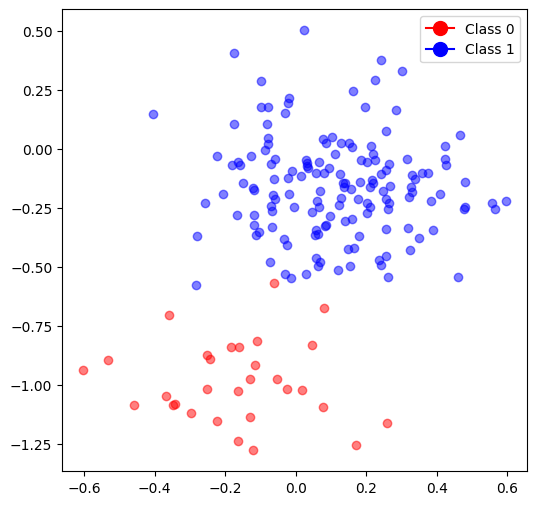

In [12]:
fig = plt.figure(figsize=(6,6))

# plot negatives in red
plt.scatter(X[y[:,0]==0,0], \
            X[y[:,0]==0,1], \
            alpha = 0.5,\
            c = 'red')

# and positives in blue
plt.scatter(x=X[y[:,0]==1,0], \
            y=X[y[:,0]==1,1], \
            alpha = 0.5, \
            c = 'blue')

P=1
N=0
legend_elements = [ Line2D([0], [0], marker='o', color='r',\
                    label='Class %d'%N, markerfacecolor='r',\
                    markersize=10),\
                    Line2D([0], [0], marker='o', color='b',\
                    label='Class %d'%P, markerfacecolor='b',\
                    markersize=10) ]

plt.legend(handles=legend_elements, loc='best')
plt.show()


### <font style="background-color: #f7dc6f">2.1.3. Let's train the logistic regressor and plot the loss curve</font>

In [13]:
def get_logistic_regression_result(Xtilde, y, learning_rate=0.5, num_iterations=1000, return_history=True):
    """
    Trains a logistic regression model using gradient descent.

    This auxiliary function wraps the call to `train_logistic()` and is
    used to enable automatic testing of logistic regression training.

    In submission

    :param Xtilde: design matrix with bias term included
    :type Xtilde: np.ndarray of shape (N, d+1)
    :param y: binary class labels
    :type y: np.ndarray of shape (N, 1)
    :param learning_rate: step size for gradient descent
    :type learning_rate: float
    :param num_iterations: number of gradient descent iterations
    :type num_iterations: int
    :param return_history: whether to return loss history
    :type return_history: bool
    :return: final weight vector and (optionally) loss history
    :rtype: tuple (np.ndarray, list of float)
    """
    np.random.seed(567) # Do not change this line!

    # Replace the right hand side below with a call to the
    # train_logistic() function defined above. Use parameter return_history=True

    w_final, loss_history = train_logistic(Xtilde, y,
                                         learning_rate=learning_rate,
                                         w0=None,
                                         num_iterations=num_iterations,
                                         return_history=return_history)

    return w_final, loss_history



In [14]:
# TEST CELL
w_final, loss_hist = get_logistic_regression_result(Xtilde, y)

assert loss_hist[-1] < loss_hist[0], "Test for get_logistic_regression_result failed: Loss did not decrease"



Final weight:
 [[5.84672125]
 [3.2835674 ]
 [8.29269888]]

Final loss:
 0.04837042989861763


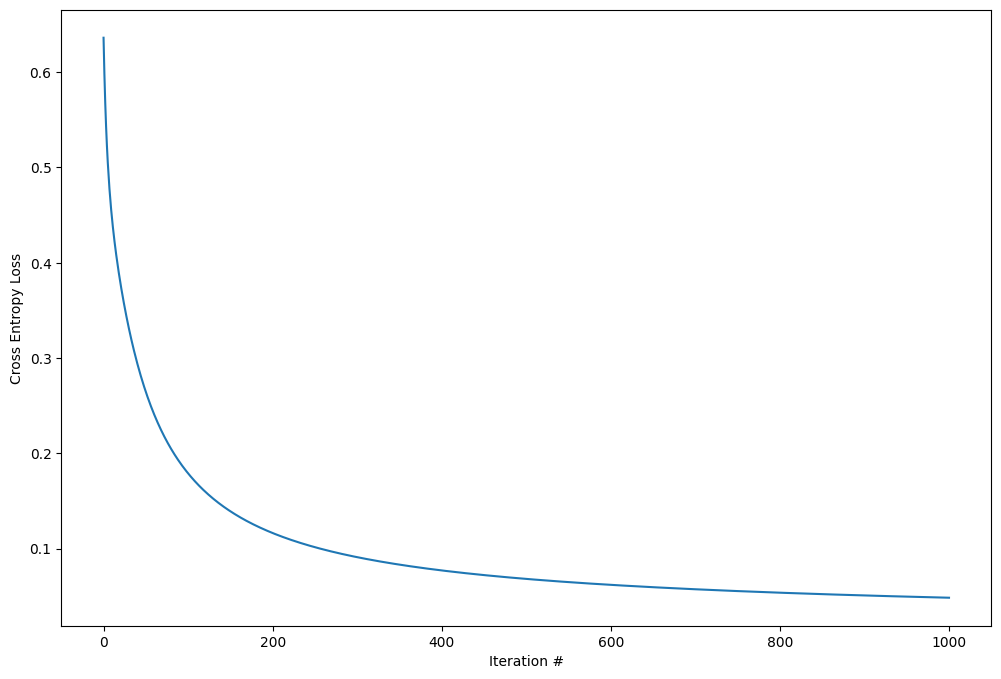

In [15]:
w_logistic, loss = get_logistic_regression_result(Xtilde, y)
print()
print("Final weight:\n", w_logistic)
print()
print("Final loss:\n", loss[-1])

plt.figure(figsize = (12, 8))
plt.plot(loss)
plt.xlabel('Iteration #')
plt.ylabel('Cross Entropy Loss')
plt.show()

### 2.1.4. Now, let's plot the decision boundary

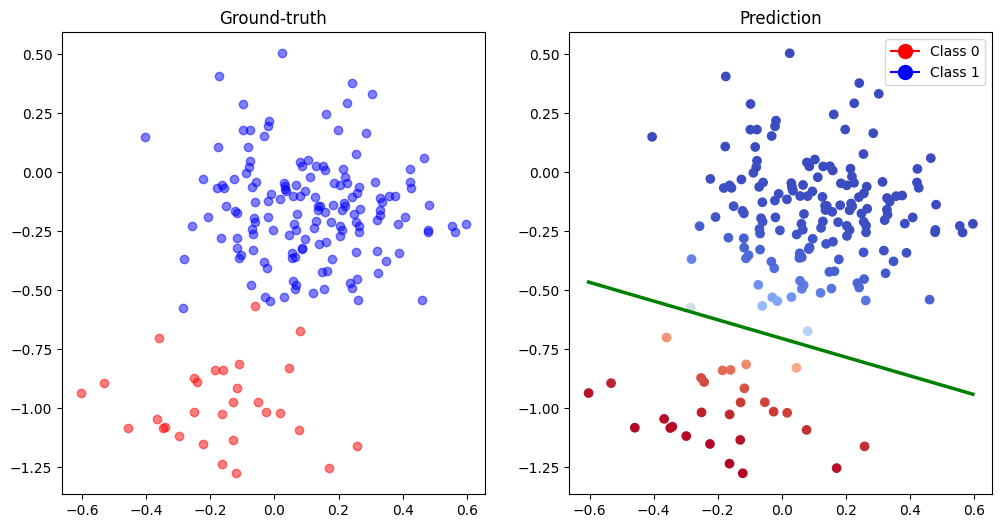

In [16]:
x1min = min(X[:,0])
x1max = max(X[:,0])
x2min = min(X[:,1])
x2max = max(X[:,1])

y_pred = predict_logistic(Xtilde, w_logistic)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax1.set_title("Ground-truth")

# plot negatives in red
ax1.scatter(X[y[:,0]==0,0], \
            X[y[:,0]==0,1], \
            alpha = 0.5, \
            c = 'red')

# and positives in blue
ax1.scatter(x=X[y[:,0]==1,0], \
            y=X[y[:,0]==1,1], \
            alpha = 0.5, \
            c = 'blue')

ax2 = fig.add_subplot(122)

ax2.set_title("Prediction")
ax2.scatter(x = X[:,0], y = X[:,1], c = -y_pred, cmap = 'coolwarm')
ax2.legend(handles=legend_elements, loc='best')
#ax2.set_xlim([x1min-1, x1max+1])
#ax2.set_ylim([x2min-1, x2max+1])

p1 = (x1min, -(w_logistic[0] + (x1min)*w_logistic[1])/w_logistic[2])
p2 = (x1max, -(w_logistic[0] + (x1max)*w_logistic[1])/w_logistic[2])

lines = ax2.plot([p1[0], p2[0]], [p1[1], p2[1]], '-')
plt.setp(lines, color='g', linewidth=2.5)

plt.show()


### <font style="background-color: #f7dc6f">2.1.5.  Counting errors</font>

In [17]:
def count_errors(y, y_pred):
    """
    Function to count the numbers of missclassifications
    :param y: binary class labels
    :type y: np.ndarray of shape (N, 1)
    :param y_pred: binary class predicted labels
    :type y_pred: np.ndarray of shape (N, 1)
    """
    # Convert predictions to binary classes using 0.5 threshold
    # y_pred contains probabilities [0,1], need to convert to binary {0,1}
    y_pred_binary = (y_pred >= 0.5).astype(int)

    # Count misclassifications by comparing predicted vs true labels
    errors = np.sum(y != y_pred_binary)

    return int(errors)

In [18]:
# TEST CELL
y_pred_test = np.array([[0.4], [0.7]])
y_test = np.array([[1.], [1.]])
expected_num_errors = 1
assert expected_num_errors == count_errors(y_test, y_pred_test), "Error for count_errors function. Wrong num of missclassfications."


In [19]:
y_pred = predict_logistic(Xtilde, w_logistic)
errors = count_errors(y, y_pred)
print("Number of misclassified examples: ", errors)

Number of misclassified examples:  2


## 2.2.  2D data, overlapping or unbalanced blobs

Feel free to experiment variations regarding total number of points, spread or number of points in each class, learning rate.

# <font style="background-color:#abebc6">3. More than 2 input variables</font>

To this end, we will play with the dataset we have collected. The file with the dataset is <tt>dataMAC0460_5832.csv</tt>

In [20]:
"""
# Colab + Drive
from google.colab import drive
drive.mount('/content/drive')

# Load File
df = pd.read_csv('/content/drive/MyDrive/dataMAC0460_5832.csv')
df.head()
"""

Mounted at /content/drive


,Sex,Age,Height,Weight,Shoe number
0,Female,53,154,59,36
1,Male,23,170,56,40
2,Female,23,167,63,37
3,Male,21,178,78,40
4,Female,25,153,58,36


In [ ]:
# load the dataset
df = pd.read_csv('dataMAC0460_5832.csv')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'dataMAC0460_5832.csv'

In [21]:
df1 = df.replace('Female', 0)
df = df1.replace('Male', 1)

<ipython-input-21-69bc2768a1ff>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df1.replace('Male', 1)


In [22]:
df.head()

,Sex,Age,Height,Weight,Shoe number
0,0,53,154,59,36
1,1,23,170,56,40
2,0,23,167,63,37
3,1,21,178,78,40
4,0,25,153,58,36


In [23]:
y = df[['Sex']].to_numpy()
print(y.shape)

(257, 1)


In [24]:
df = df.drop(columns=['Sex'])
df =(df-df.mean())/df.std()
df.describe()

,Age,Height,Weight,Shoe number
count,2.570000e+02,2.570000e+02,2.570000e+02,2.570000e+02
mean,1.175022e-16,7.879560e-16,-1.503337e-16,-6.186145e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.914199e+00,-1.093171e+01,-3.677728e+00,-6.143107e+00
25%,-5.618648e-01,-4.288367e-01,-6.427588e-01,-8.284729e-01
50%,-4.116054e-01,5.484808e-02,-2.337743e-02,1.680210e-01
75%,3.917267e-02,6.076307e-01,5.960040e-01,8.323503e-01
max,4.021046e+00,1.644098e+00,4.807797e+00,2.161009e+00


In [25]:
X = df.to_numpy()



Number of input variables = 1

Final weight:
 [[ 0.80182118]
 [-0.43760021]]
Final loss:
 0.6012137889812339
Number of misclassified examples:  78


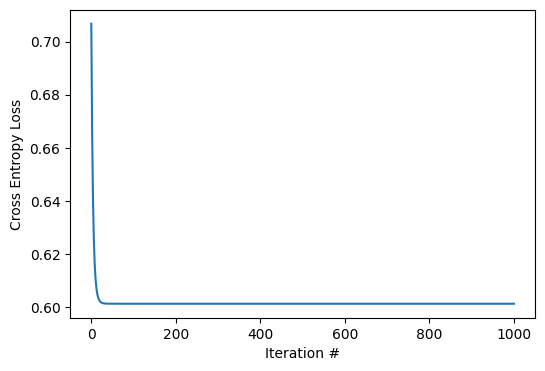



Number of input variables = 2

Final weight:
 [[ 1.18369815]
 [-0.44105872]
 [ 3.21151401]]
Final loss:
 0.37189199017875874
Number of misclassified examples:  36


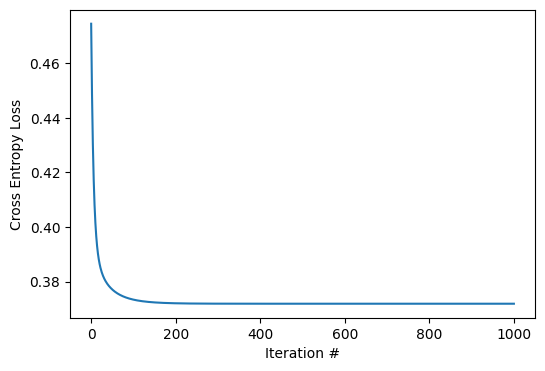



Number of input variables = 3

Final weight:
 [[ 1.18351569]
 [-0.4844637 ]
 [ 3.02726523]
 [ 0.19866767]]
Final loss:
 0.3708388617310754
Number of misclassified examples:  36


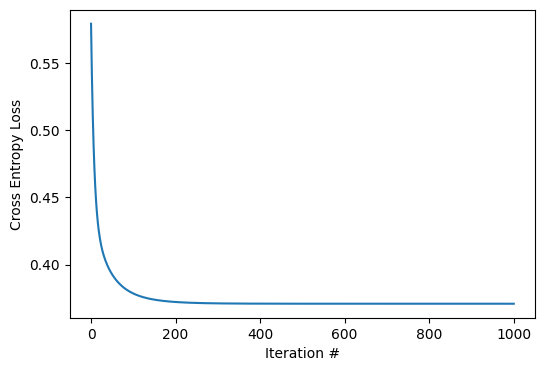



Number of input variables = 4

Final weight:
 [[ 1.81473361]
 [-0.43440536]
 [-0.08175213]
 [-0.2027911 ]
 [ 3.96646551]]
Final loss:
 0.25186014142172775
Number of misclassified examples:  28


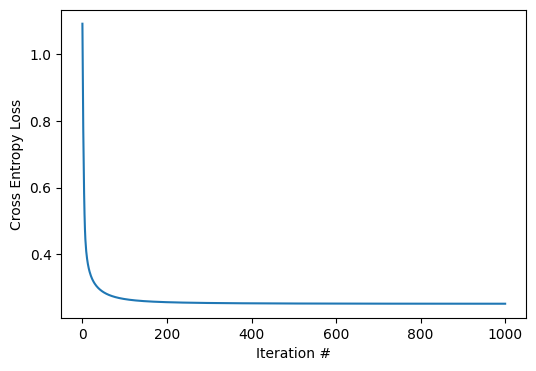

In [26]:
for i in range(4):

  print("\n\nNumber of input variables = %d\n"%(i+1))

  Xtilde = np.concatenate([np.ones((len(X), 1)), X[:,0:i+1]], axis = 1)  # data matrix, with left column of ONEs

  w_logistic, loss = train_logistic(Xtilde, y, \
                                  learning_rate = 0.5,\
                                  num_iterations = 1000,\
                                  return_history = True)

  # Print the final weight and loss
  print("Final weight:\n", w_logistic)
  print("Final loss:\n", loss[-1])
  y_pred = predict_logistic(Xtilde, w_logistic)
  errors = count_errors(y, y_pred)
  print("Number of misclassified examples: ", errors)

  plt.figure(figsize = (6,4))
  plt.plot(loss)
  plt.xlabel('Iteration #')
  plt.ylabel('Cross Entropy Loss')
  plt.show()
